In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to C:\Users\Srikar
[nltk_data]     Gupta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
  Using cached wordcloud-1.9.3-cp312-cp312-win_amd64.whl.metadata (3.5 kB)
Using cached wordcloud-1.9.3-cp312-cp312-win_amd64.whl (301 kB)
Note: you may need to restart the kernel to use updated packages.


In [60]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

### EDA

In [5]:
df = pd.read_csv(r"Data\amazon_alexa.tsv", delimiter = "\t",quoting =3)
print(f"Dataset shape : {df.shape} ") 

Dataset shape : (3150, 5) 


In [6]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [8]:
print(f"Feature names : {df.columns.values}")

Feature names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [9]:
df.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [10]:
df[df['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [11]:
df.dropna(inplace=True)

In [16]:
print("Dataset shape after dropping the null values :",df.shape)

Dataset shape after dropping the null values : (3149, 5)


In [18]:
df['length'] = df['verified_reviews'].apply(len)
df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [19]:
df.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

rating, feedback, length are integer variables

date, variation, verified_reviews are string values

In [20]:
print("Rating value count : ",df['rating'].value_counts())

Rating value count :  rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


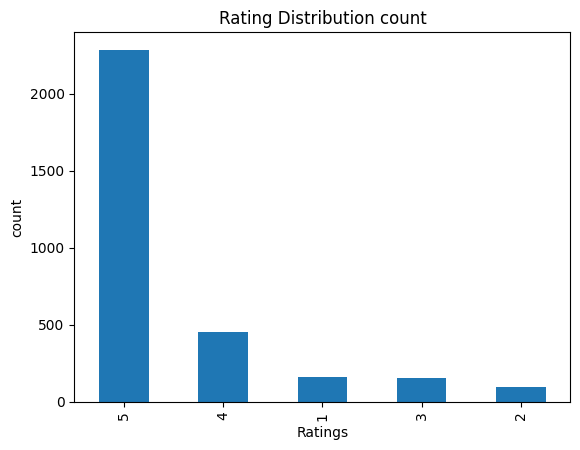

In [21]:
df['rating'].value_counts().plot.bar()
plt.title("Rating Distribution count")
plt.xlabel("Ratings")
plt.ylabel('count')
plt.show()

In [23]:
print(" Rating value count - percentage distribution: ", round(df['rating'].value_counts() /df.shape[0]*100,2))

 Rating value count - percentage distribution:  rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


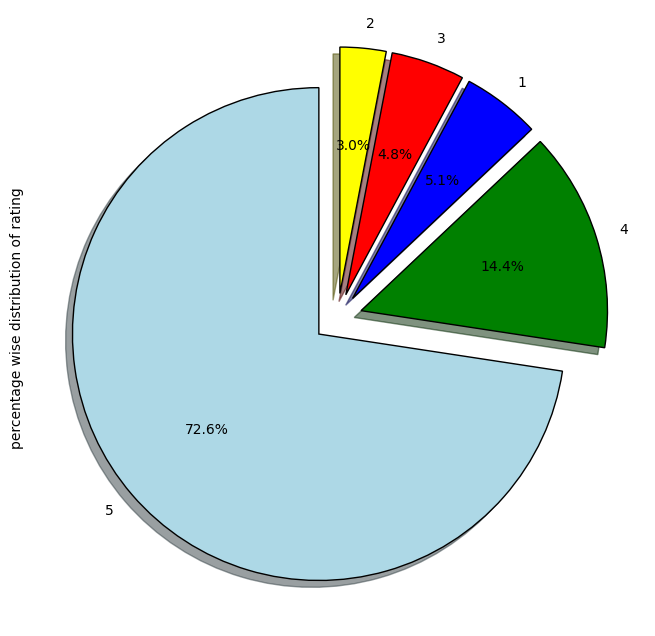

In [26]:
fig = plt.figure(figsize = (8,8))
colors = ('lightblue','green','blue','red','yellow')
wp = {'linewidth':1,"edgecolor":'black'}
tags = df['rating'].value_counts()/df.shape[0]
explode = (0.1,0.1,0.1,0.1,0.1)
tags.plot(kind = 'pie', autopct = "%1.1f%%", shadow = True, colors=colors,startangle = 90, wedgeprops =wp, explode = explode, label = 'percentage wise distribution of rating')
from io import BytesIO
graph = BytesIO()
fig.savefig(graph, format = 'png')

Analyzing feedback column

In [27]:
print("Feedback value count : ",df['feedback'].value_counts())

Feedback value count :  feedback
1    2893
0     256
Name: count, dtype: int64


There are 2 distinct values of 'feedback' present - 0 and 1. Let's see what kind of review each value corresponds to.

feedback value = 0

In [31]:
review_0 = df[df['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [34]:
review_1 = df[df['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


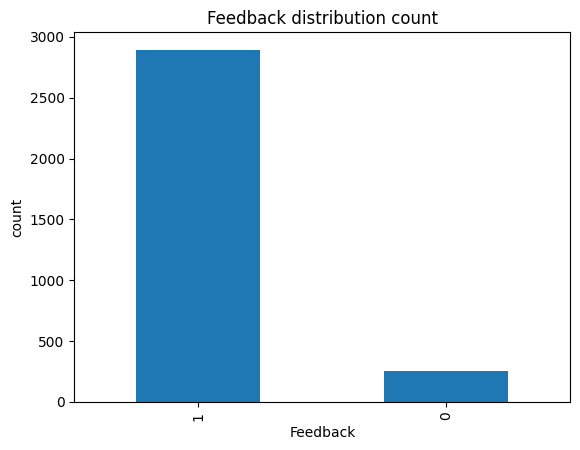

In [36]:
df['feedback'].value_counts().plot.bar()
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('count')
plt.show()

In [38]:
print("Feedback percentage distribution :",round(df['feedback'].value_counts()/df.shape[0] * 100, 2))

Feedback percentage distribution : feedback
1    91.87
0     8.13
Name: count, dtype: float64


<Axes: ylabel='Percentage wise distrbution of feedback'>

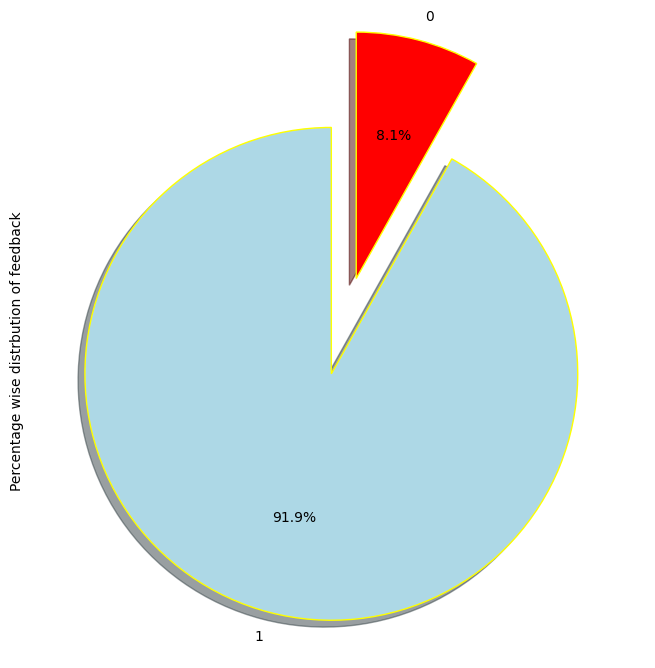

In [39]:
fig = plt.figure(figsize = (8,8))
colors = ('lightblue','red')
wp = {'linewidth':1,'edgecolor':'yellow'}
tags = df['feedback'].value_counts()/df.shape[0]
explode = (0.1,0.3)
tags.plot(kind = 'pie', autopct = '%1.1f%%', shadow =True, colors = colors, startangle = 90, wedgeprops = wp, explode= explode, label = 'Percentage wise distrbution of feedback')

In [40]:
df[df['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [41]:
df[df['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

If rating of a review is 1 or 2 then the feedback is 0 (negative) and if the rating is 3, 4 or 5 then the feedback is 1 (positive).

Analyzing variation column

In [42]:
df['variation'].value_counts()

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

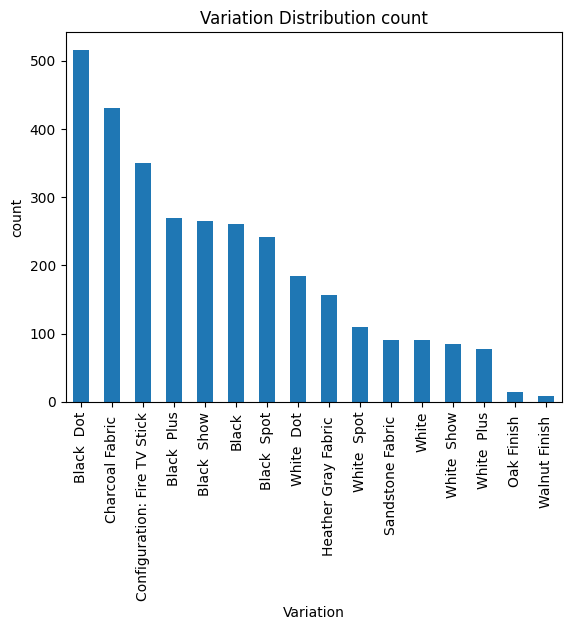

In [43]:
df['variation'].value_counts().plot.bar()
plt.title("Variation Distribution count")
plt.xlabel('Variation')
plt.ylabel('count')
plt.show()

In [44]:
print('Variation value count - percentage distribution: ',round(df['variation'].value_counts()/df.shape[0] * 100, 2))

Variation value count - percentage distribution:  variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


In [45]:
df.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

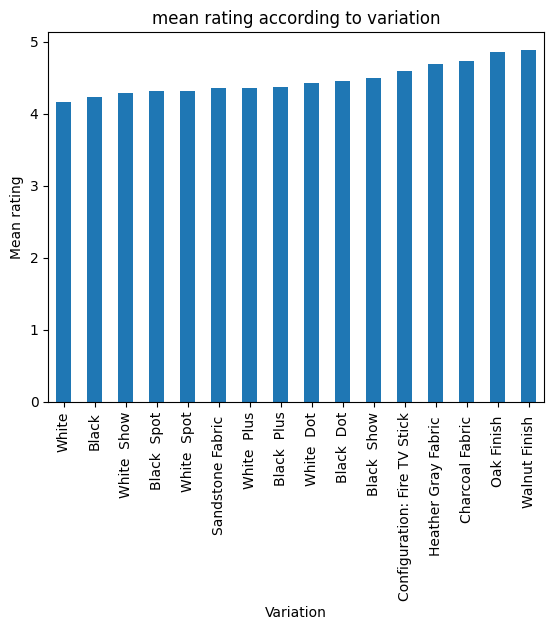

In [46]:
df.groupby('variation')['rating'].mean().sort_values().plot.bar()
plt.title("mean rating according to variation")
plt.xlabel("Variation")
plt.ylabel("Mean rating")
plt.show()

In [50]:
df.columns

Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback',
       'length'],
      dtype='object')

Analyzing 'verified_reviews' column

This column contains the textual review given by the user for a variation for the product.

In [51]:
df['length'].describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

[Text(0.5, 1.0, 'Distribuion of length of review')]

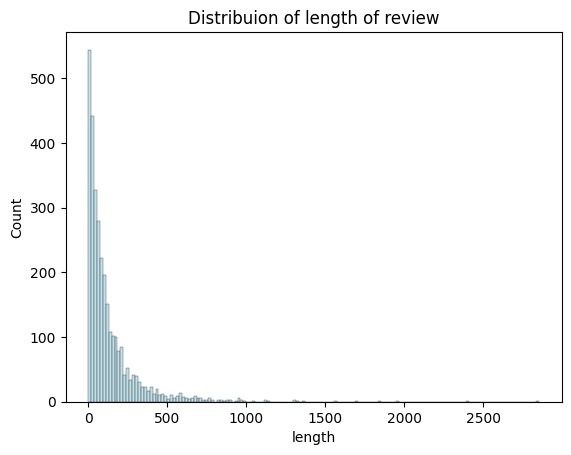

In [54]:
sns.histplot(df['length'], color= 'lightblue').set(title = 'Distribuion of length of review')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

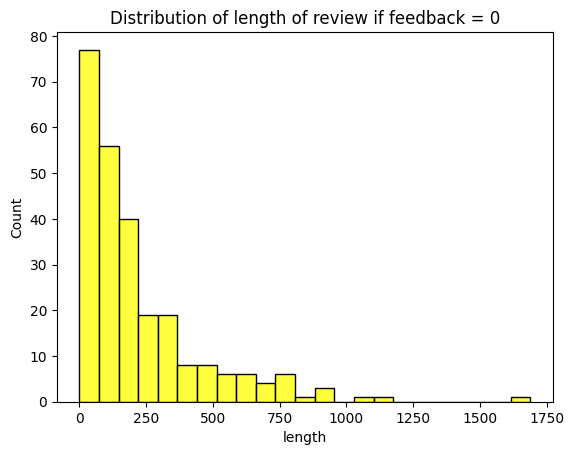

In [55]:
sns.histplot(df[df['feedback'] == 0]['length'], color = 'yellow').set(title = "Distribution of length of review if feedback = 0")

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

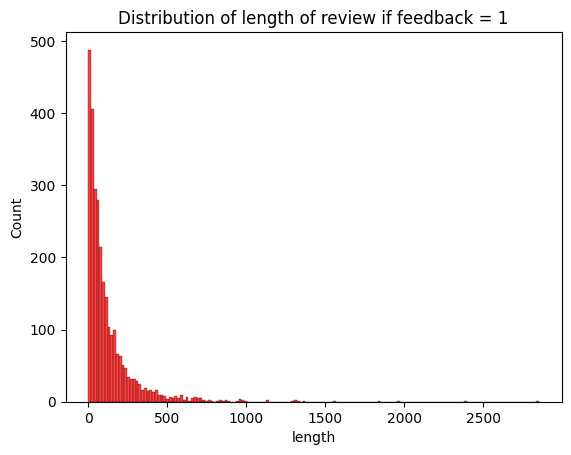

In [57]:
sns.histplot(df[df['feedback'] == 1]['length'], color ='red').set(title = 'Distribution of length of review if feedback = 1')

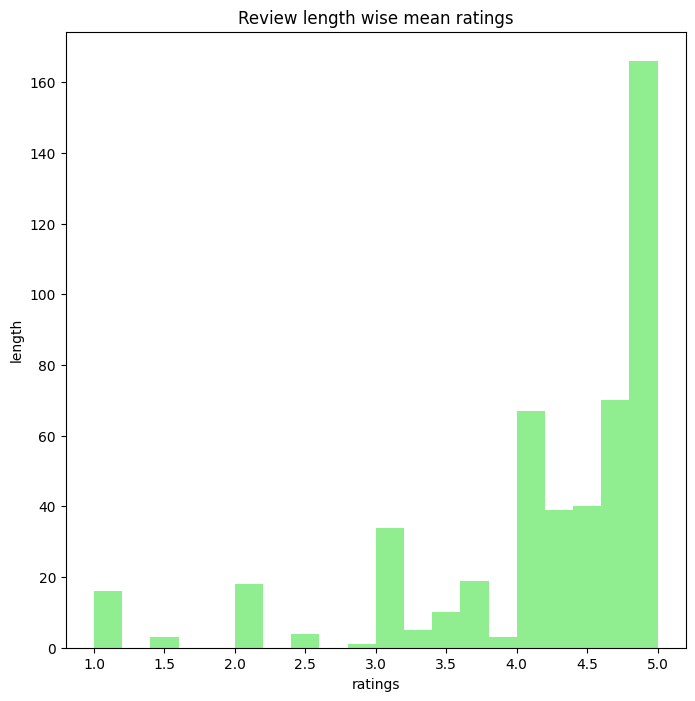

In [59]:
df.groupby('length')['rating'].mean().plot.hist(color = 'lightgreen', figsize = (8,8), bins =20)
plt.title("Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [63]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df.verified_reviews)

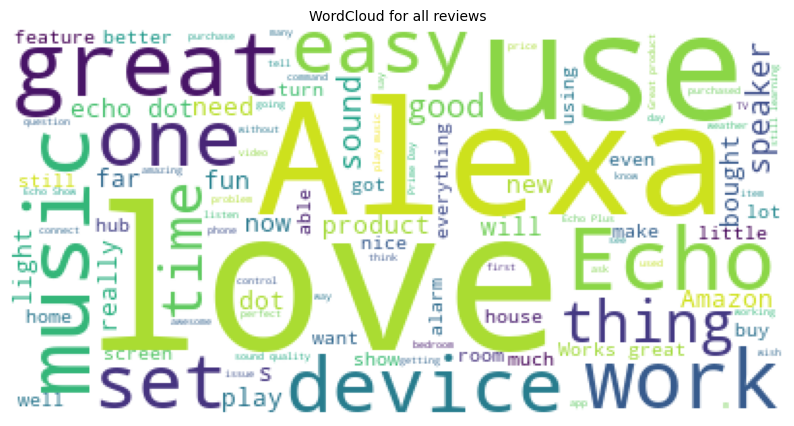

In [64]:
reviews = " ".join([review for review in df['verified_reviews']])

wc = WordCloud(background_color = 'white', max_words = 100)

plt.figure(figsize = (10,10))
plt.imshow(wc.generate(reviews))
plt.title('WordCloud for all reviews', fontsize = 10)
plt.axis('off')
plt.show()

In [67]:
negative_reviews = " ".join([review for review in df[df['feedback'] == 0]['verified_reviews']])
negative_reviews = negative_reviews.lower().split()

positive_reviews = " ".join([review for review in df[df['feedback'] == 1]['verified_reviews']])
positive_reviews = positive_reviews.lower().split()

unique_negative = [x for x in negative_reviews if x not in positive_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in positive_reviews if x not in negative_reviews]
unique_positive = " ".join(unique_positive)

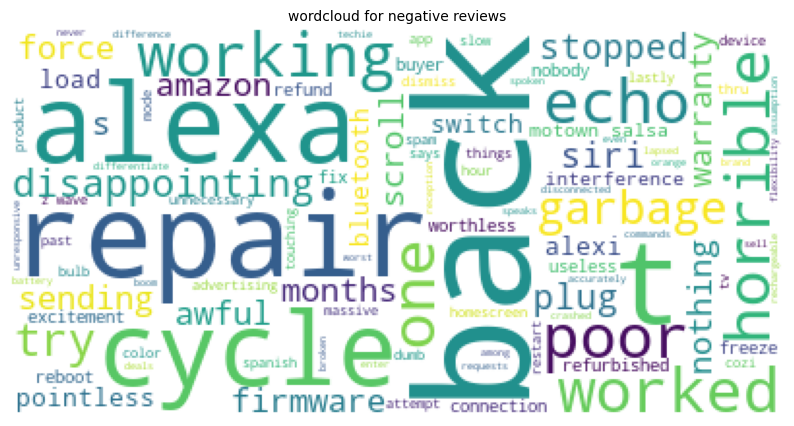

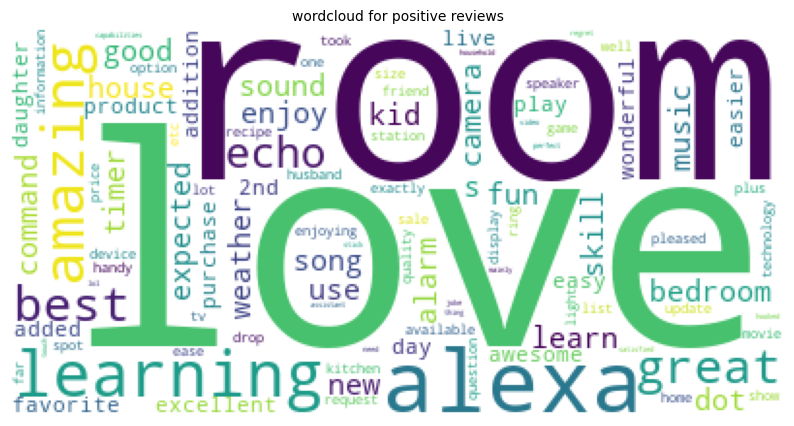

In [69]:
wc = WordCloud(background_color = 'white', max_words = 100)

plt.figure(figsize = (10, 10))
plt.imshow(wc.generate(unique_negative))
plt.title('wordcloud for negative reviews', fontsize = 10)
plt.axis('off')
plt.show()

plt.figure(figsize = (10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('wordcloud for positive reviews', fontsize = 10)
plt.axis('off')
plt.show()

Processing and Modelling

To build the corpus from the 'verified_reviews' we perform the following -

1. Replace any non alphabet characters with a space
2. Convert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [70]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, df.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ',df.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

In [71]:
cv = CountVectorizer(max_features = 2500)

X = cv.fit_transform(corpus).toarray()
y = df['feedback'].values

In [73]:
pickle.dump(cv, open('Models/CountVectorizer.pkl','wb'))

In [74]:
print("X shape :", X.shape)
print("Y shape :", y.shape)

X shape : (3149, 2500)
Y shape : (3149,)


In [76]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3, random_state = 20)

print("X train :", X_train.shape)
print("y_train :",y_train.shape)
print("X_test :",X_test.shape)
print("y_test : ", y_test.shape)

X train : (2204, 2500)
y_train : (2204,)
X_test : (945, 2500)
y_test :  (945,)


In [77]:
print("X train max value :",X_train.max())
print("X test max value :",X_test.max())

X train max value : 8
X test max value : 12


In [78]:
scaler = MinMaxScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [79]:
pickle.dump(scaler, open('Models/scaler.pkl','wb'))

RandomForest

In [82]:
rf = RandomForestClassifier()
rf.fit(X_train_scaler,y_train)

RandomForestClassifier()

In [83]:
print("training accuracy :",rf.score(X_train_scaler, y_train))
print("testing accuracy :",rf.score(X_test_scaler,y_test))

training accuracy : 0.9936479128856625
testing accuracy : 0.9343915343915344


In [84]:
y_pred = rf.predict(X_test_scaler)

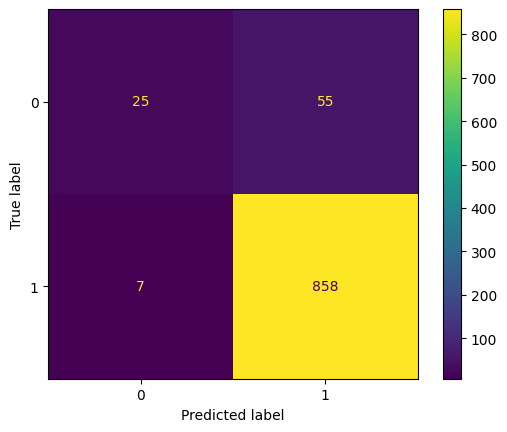

In [85]:
cm = confusion_matrix(y_test,y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rf.classes_)
cm_display.plot()
plt.show()

In [87]:
#K fold cross-validation
accuracy = cross_val_score(estimator = rf, X = X_train_scaler, y = y_train, cv = 10)

print("Accuracy :", accuracy.mean())
print("Standard Variance :", accuracy.std())

Accuracy : 0.9369374742904155
Standard Variance : 0.007665784945154453


In [88]:
#Applying grid search to get the optimal parameters on random forest
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [89]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scaler, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [90]:
#Getting the best parameters from the grid search
print("Best Parameter Combination : {}".format(grid_search.best_params_))

print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_pred))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 12, 'n_estimators': 300}
Cross validation mean accuracy on train set : 96.81261343012704
Cross validation mean accuracy on test set : 92.30943738656987
Accuracy score for test set : 0.9343915343915344


In [91]:
xgb = XGBClassifier()
xgb.fit(X_train_scaler, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [92]:
print("Training accuracy :", xgb.score(X_train_scaler, y_train))
print("Testing accuracy :", xgb.score(X_test_scaler,y_test))

Training accuracy : 0.9732304900181489
Testing accuracy : 0.9365079365079365


[[ 33  47]
 [ 17 848]]


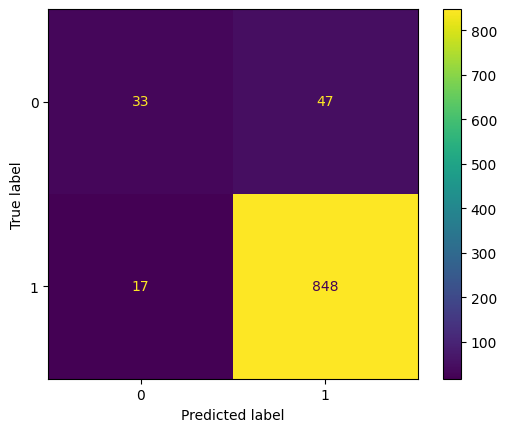

In [94]:
y_pred = xgb.predict(X_test)

cm = confusion_matrix(y_test,y_pred)
print(cm)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb.classes_)
cm_display.plot()
plt.show()

In [96]:
pickle.dump(xgb,open('Models/xgb.pkl','wb'))

Decision Tree Classifer

Training accuracy : 0.9936479128856625
Testing accuracy : 0.9174603174603174
[[ 41  39]
 [114 751]]


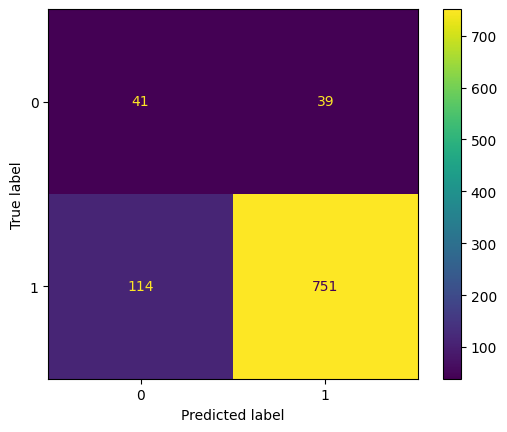

In [97]:
dt = DecisionTreeClassifier()
dt.fit(X_train_scaler,y_train)

print("Training accuracy :",dt.score(X_train_scaler,y_train))
print("Testing accuracy :",dt.score(X_test_scaler, y_test))

y_pred = dt.predict(X_test)

cm = confusion_matrix(y_test,y_pred)
print(cm)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = dt.classes_)
cm_display.plot()
plt.show()